# Extend AI Machine Learning Engineer Assessment
Solved in 2 parts:
1. Localize anomalies
2. Identify anomalies

In order to solve this problem, I divided it into 2 parts. The first model localize the anomalities. For instance, given a large image of a piece of wood, the first model would create a "heatmap" of where the anomalies are potentially located. From this heat map, we can output managable and centered smaller images of a single anomaly and then classify it.

The second model tries to classify the potential anomalies with a simple semi-supervised machine learning model. I labeled the training set of smaller images and trained a classification model on it.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [2]:
!rm -rf .ipynb_checkpoints
!rm -rf part_1_data/.ipynb_checkpoints
!rm -rf part_2_data/.ipynb_checkpoints
!rm -rf sample_data
!ls -a part_1_data/

.  ..  anomaly	.DS_Store  perfect


In [3]:
data_dir = pathlib.Path('part_1_data')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

7


In [4]:
batch_size = 8
img_height = 384 * 2 #1952 
img_width = 512 * 2 #2592

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=256,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print(np.concatenate([y for x, y in train_ds], axis=0))

Found 7 files belonging to 2 classes.
Using 5 files for training.
[1 0 0 1 1]


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  seed=256,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print(np.concatenate([y for x, y in val_ds], axis=0))

Found 7 files belonging to 2 classes.
Using 2 files for validation.
[0 0]


In [7]:
class_names = train_ds.class_names
print(class_names)

['anomaly', 'perfect']


In [8]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.Rescaling(1./255),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.5, 0.5),
])

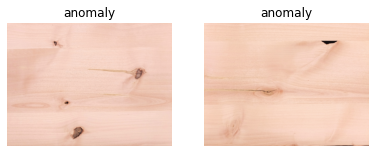

In [9]:
plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(3):
    for i in range(batch_size):
        if i >= len(images):
          break
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

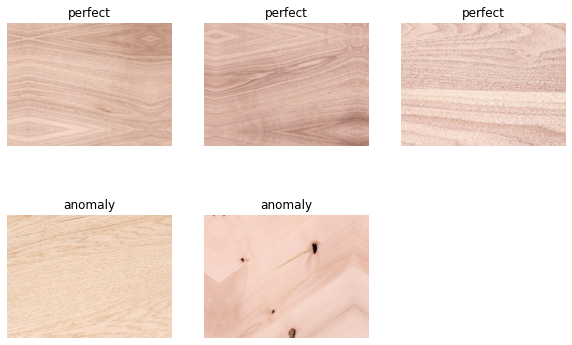

In [10]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(batch_size):
        if i >= len(images):
          break
        ax = plt.subplot(3, 3, i + 1)
        image = data_augmentation(images[i])
        plt.imshow(image)
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Model 1
This model localize the anomalities in the wood using the activation layer of the predictive model. I generated a heatmap and superposed it on top of the original image as a proof of concept. Some notes:


*   I did not try to enhance the trainning since the data set is so small, it was not worth it.
*   I used transfer learning from VGG16 since the original dataset is too small to train one without overfitting.
*   I augmented the data, as this step would be part of the normal flow for training a model with small dataset. But I do believe I could make the data set better by manually augmenting it.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *


def get_model_1():
  vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (img_height, img_width, 3))
  for layer in vgg_conv.layers[:-8]:
      layer.trainable = False

  x = vgg_conv.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1, activation="softmax")(x)

  model = Model(vgg_conv.input, x)
  model.compile(loss = "categorical_crossentropy", optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

  return model

model = get_model_1()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1
)

1/1 [==============================] - 26s 26s/step - loss: 0.0000e+00 - accuracy: 0.6000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [14]:
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

In [15]:
import scipy as sp
from skimage.feature import peak_local_max

def find_local_maxima(data):
  # TODO
  return ()

def plot_activation(img, label):
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)
    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]
    intermediate = Model(model.input,
                         model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)
    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])
    act_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)

    out = np.dot(act_maps.reshape((img.shape[0]*img.shape[1],512)), class_weights)
    out = out.reshape(img.shape[0],img.shape[1])
    
    # local_maximas = find_local_maxima(out)
    # plt.plot(local_maximas[:,0], local_maximas[:,1], 'ro')

    plt.imshow(img.astype('float32').reshape(img.shape[0],
               img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    title = 'Crack' if pred_class == 1 else 'No Crack'
    label = 'Crack' if label == 1 else 'No Crack'
    plt.title("Prediction: %s - Truth: %s" % (title, label))


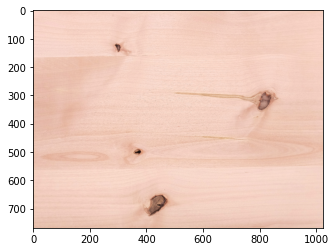

In [16]:
image_batch, labels_batch = next(iter(val_ds))
first_image = image_batch[0]/255.0, labels_batch[0]
second_image = image_batch[1]/255.0, labels_batch[1]
plt.imshow(first_image[0])

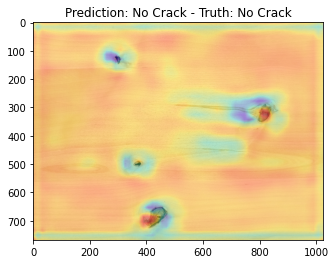

In [17]:
plot_activation(first_image[0], first_image[1])

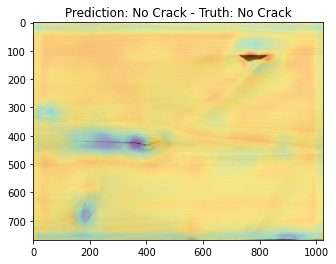

In [18]:
plot_activation(second_image[0], second_image[1])

### Notes
I did not impliment a function to find the maxima of the activation function. But from my plots above, I am convinced that a simple algorithm could find all potential local maximas and and simply export smaller images where the centers of the outputed images are the local maximas.

Moving on to the second part.

## Part 2

In this part, I use a dataset I created manually with imperfection for classification. I divided them into 3 categories: 

1.   Perfect
2.   Knots
3.   Cracks

See the files for a better overview of the small dataset I created. By no means, this model would be performing well in production. My goal here was to have a end-to-end proof of concept where given one of the image in the dataset I would output a functional and informative anomaly classification.



In [251]:
data_dir = pathlib.Path('part_2_data')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

45


In [252]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=24,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print(np.concatenate([y for x, y in train_ds], axis=0))

Found 45 files belonging to 3 classes.
Using 27 files for training.
[0 2 2 1 2 2 2 2 2 2 1 0 2 1 2 1 2 2 2 0 2 2 0 1 2 1 2]


In [253]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  seed=24,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print(np.concatenate([y for x, y in val_ds], axis=0))

Found 45 files belonging to 3 classes.
Using 18 files for validation.
[2 2 2 1 0 0 0 1 0 0 2 1 1 2 2 2 1 2]


In [254]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.Rescaling(1./255),
  layers.RandomRotation(0.5),
  layers.RandomZoom(0.3, 0.3),
])

class_names = train_ds.class_names
print(class_names)

['cracks', 'knots', 'perfect']


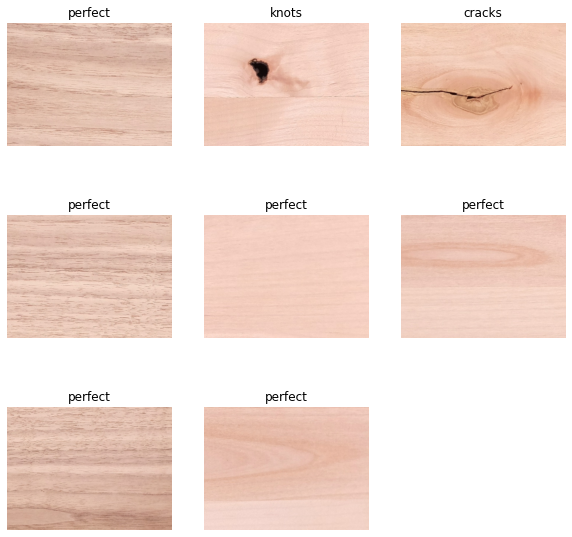

In [255]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(batch_size):
        if i >= 9:
          break
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

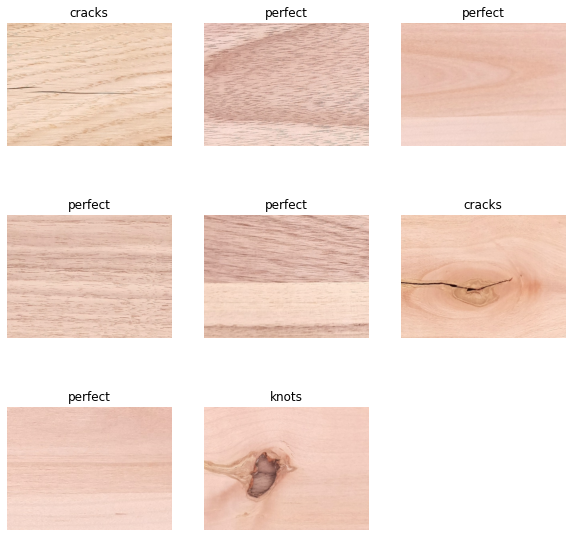

In [256]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(batch_size):
        if i >= 9:
          break
        ax = plt.subplot(3, 3, i + 1)
        image = data_augmentation(images[i])
        plt.imshow(image)
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [257]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [270]:
def get_model_2():
  model = Sequential()
  model.add(layers.Resizing(64, 64, interpolation='bilinear', crop_to_aspect_ratio=True))
 
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.LayerNormalization(axis=1))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.LayerNormalization(axis=1))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(3))

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  return model

model = get_model_2()

In [271]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5)

Epoch 1/5
4/4 [==============================] - 2s 133ms/step - loss: 2.5339 - accuracy: 0.4444 - val_loss: 4.3444 - val_accuracy: 0.4444
Epoch 2/5
4/4 [==============================] - 0s 43ms/step - loss: 0.6125 - accuracy: 0.7407 - val_loss: 1.1427 - val_accuracy: 0.5556
Epoch 3/5
4/4 [==============================] - 0s 44ms/step - loss: 0.1100 - accuracy: 0.9630 - val_loss: 1.0467 - val_accuracy: 0.5000
Epoch 4/5
4/4 [==============================] - 0s 44ms/step - loss: 0.0689 - accuracy: 0.9630 - val_loss: 1.2241 - val_accuracy: 0.6111
Epoch 5/5
4/4 [==============================] - 0s 46ms/step - loss: 0.0183 - accuracy: 1.0000 - val_loss: 1.2935 - val_accuracy: 0.6111


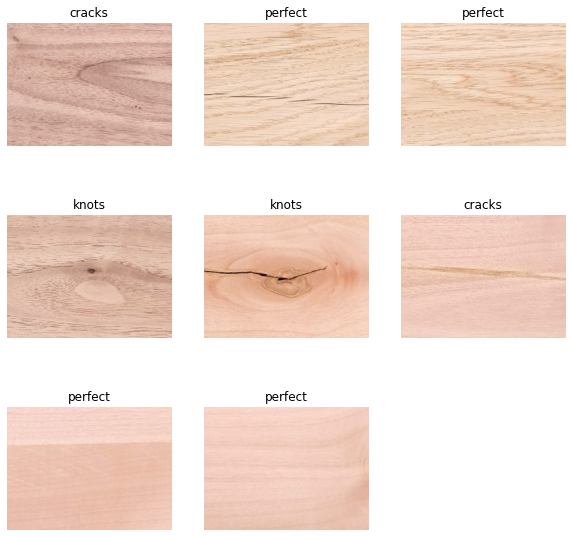

In [273]:
plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):
    for i in range(batch_size):
        if i >= 9:
          break
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred = model.predict(images[i][np.newaxis,:,:,:]/255.0)

        pred_ = np.argmax(pred)
        
        plt.title("%s" % (class_names[int(pred_)]))
        plt.axis("off")